In [1]:
"""
Author MYING
Using Python 3.9.7
"""
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11,8
import seaborn as sns
sns.set_context("talk")
plt.figure()

from scipy.integrate import solve_ivp


<Figure size 1100x800 with 0 Axes>

In [2]:

#import re
#import numpy as np
#Note import re is required for regular expression of strings!

def parse_reaction_string(reaction_string):
    """Parse a reaction string into reactants, products, and rate constant.

    Args:
        reaction_string (str): The input reaction string.

    Returns:
        tuple: A tuple containing three elements - reactants (str), products (str), and rate constant (str).

    Raises:
        ValueError: If the input reaction string does not have the expected format.
    """
    # Split the reaction string by '->' to separate reactants and products
    reaction_parts = reaction_string.split('->')
    
    if len(reaction_parts) != 2:
        raise ValueError("Invalid reaction string format: " + reaction_string)
    
    # Extract reactants and the second half of the reaction string
    reactants, second_half_string = reaction_parts[0].strip(), reaction_parts[1].strip()
    
    # Split the second half of the reaction string by ',' to separate products and rate constant
    second_half_parts = second_half_string.split(',')
    
    if len(second_half_parts) != 2:
        raise ValueError("Invalid reaction string format: " + reaction_string)
    
    # Extract products and rate constant
    products, rate_constant = second_half_parts[0].strip(), second_half_parts[1].strip()
    
    return reactants, products, rate_constant

# Example usage:
input_string = "A + 2B -> C, k1"
reactants, products, rate_constant = parse_reaction_string(input_string)
print(products)  # Output: C


C


In [3]:

#import re

def parse_stoichiometry_string(reactants_or_products_string):
    """Parse a stoichiometry string into a stoichiometry dictionary.

    Args:
        reactants_or_products_string (str): The input stoichiometry string.

    Returns:
        dict: A dictionary representing the stoichiometry, where keys are elements and values are coefficients.

    Raises:
        ValueError: If the input stoichiometry string has an invalid format.
    """
    # Split the input string into individual reactants by the '+' symbol
    reactants = reactants_or_products_string.split('+')
    
    # Initialize an empty dictionary to store the stoichiometry
    stoichiometry_dict = {}
    
    for reactant in reactants:
        # Remove leading and trailing white spaces
        reactant = reactant.strip()
        
        # Use regular expression to match coefficients and elements in the reactant
        match = re.match(r"([\d.]+)?\s*(\w+)", reactant)
        
        if match:
            coefficient, element = match.groups()
            if coefficient:
                coefficient = float(coefficient)
            else:
                coefficient = 1.0

            # Update the stoichiometry dictionary with the coefficient and element
            if element in stoichiometry_dict:
                stoichiometry_dict[element] += coefficient
            else:
                stoichiometry_dict[element] = coefficient
        else:
            raise ValueError(f"Invalid reactant or product format: {reactant}")

    return stoichiometry_dict


# Example usage:
input_string = "A + 1.42857  B   +3C+  A"
stoichiometry = parse_stoichiometry_string(input_string)
print(stoichiometry)  # Output: {'A': 2, 'B': 2, 'C': 1}



{'A': 2.0, 'B': 1.42857, 'C': 3.0}


In [4]:

def extract_species_dictionaries_from_reaction_strings(reaction_strings):
    """
    Extract species dictionaries, rate constants, and names from a list of reaction strings.

    Args:
        reaction_strings (list): List of reaction strings.

    Returns:
        tuple: A tuple containing species_names_set (set), rate_constant_names (list),
        reactant_dictionaries (list), and product_dictionaries (list).
    """
    species_names_set = set()
    reactant_dictionaries = []
    product_dictionaries = []
    rate_constant_values = [] # for future use, I think rate constant not from string is better for now?
    rate_constant_names = []

    for reaction_string in reaction_strings:
        # split reaction string into three entries
        reactants, products, rate_constant = parse_reaction_string(reaction_string)

        # convert to dict for reactant and product
        reactant_dict = parse_stoichiometry_string(reactants)
        product_dict = parse_stoichiometry_string(products)

        # add new names to set
        species_names_set.update(reactant_dict.keys())
        species_names_set.update(product_dict.keys())

        # append dictionaries to the respective lists
        reactant_dictionaries.append(reactant_dict)
        product_dictionaries.append(product_dict)
        
        # append rate constant to the list
        rate_constant_names.append(rate_constant)
        
    return species_names_set, rate_constant_names, reactant_dictionaries, product_dictionaries

# example
reaction_strings = ["A + B -> C, kon", "2X -> Y, kf", "C -> A + B, koff", "Y + A -> X + C, ki"]
extract_species_dictionaries_from_reaction_strings(reaction_strings)


({'A', 'B', 'C', 'X', 'Y'},
 ['kon', 'kf', 'koff', 'ki'],
 [{'A': 1.0, 'B': 1.0}, {'X': 2.0}, {'C': 1.0}, {'Y': 1.0, 'A': 1.0}],
 [{'C': 1.0}, {'Y': 1.0}, {'A': 1.0, 'B': 1.0}, {'X': 1.0, 'C': 1.0}])

In [5]:

def parse_reaction_strings(reaction_strings, VERBOSE_MODE=True, dtype=int):
    """
    Parse reaction strings into species names, rate constant names, reactant matrices, and product matrices.
    Avoid using dtype = float as long as there is no decimals in stoichiometry is advised.

    Args:
        reaction_strings (list): List of reaction strings.
        VERBOSE_MODE (bool, optional): If True, print additional information for debugging.
        dtype (type, optional): Data type for matrix values (default: float).

    Returns:
        tuple: A tuple containing species_names (list), rate_constant_names (list),
        reactant_matrix_array (numpy.ndarray), and product_matrix_array (numpy.ndarray).
    """

    rate_constant_values = []  # Placeholder

    # Extract species dictionaries, names, and count
    species_names_set, rate_constant_names, reactant_dictionaries, product_dictionaries = \
        extract_species_dictionaries_from_reaction_strings(reaction_strings)

    species_names = list(species_names_set)
    num_species = len(species_names)
    num_reactions = len(reaction_strings)

    if VERBOSE_MODE:
        print(f"species_names : {species_names}")
        print(f"reactant_dictionaries : {reactant_dictionaries}")
        print(f"product_dictionaries : {product_dictionaries}")

    # Initialize reactant and product matrices
    reactant_matrix_array = np.zeros((num_reactions, num_species), dtype=dtype)
    product_matrix_array = np.zeros((num_reactions, num_species), dtype=dtype)

    # Create a dictionary to map species names to indices
    species_to_index = {species: i for i, species in enumerate(species_names)}

    # Fill in reactant and product matrices
    for i in range(num_reactions):
        for species, stoichiometry in reactant_dictionaries[i].items():
            reactant_matrix_array[i, species_to_index[species]] = stoichiometry
        for species, stoichiometry in product_dictionaries[i].items():
            product_matrix_array[i, species_to_index[species]] = stoichiometry

    return species_names, rate_constant_names, reactant_matrix_array, product_matrix_array

# Example usage:
reaction_strings = ["A + B -> C, kon", "2X -> Y, kf", "C -> A + B, koff", "Y + A -> X + C, ki"]
species_names, reactant_matrix, product_matrix, rate_constant_names =\
        parse_reaction_strings(reaction_strings)
print("Species Names:")
print(species_names)
print("Reactant Stoichiometry Matrix:")
print(reactant_matrix)
print("Product Stoichiometry Matrix:")
print(product_matrix)
print("Rate Constant Values: Placeholder. for future use, I think rate constant not from string is better for now?")
print("Rate Constant Names:")
print(rate_constant_names)



species_names : ['B', 'X', 'C', 'A', 'Y']
reactant_dictionaries : [{'A': 1.0, 'B': 1.0}, {'X': 2.0}, {'C': 1.0}, {'Y': 1.0, 'A': 1.0}]
product_dictionaries : [{'C': 1.0}, {'Y': 1.0}, {'A': 1.0, 'B': 1.0}, {'X': 1.0, 'C': 1.0}]
Species Names:
['B', 'X', 'C', 'A', 'Y']
Reactant Stoichiometry Matrix:
['kon', 'kf', 'koff', 'ki']
Product Stoichiometry Matrix:
[[1 0 0 1 0]
 [0 2 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]]
Rate Constant Values: Placeholder. for future use, I think rate constant not from string is better for now?
Rate Constant Names:
[[0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 1 0]
 [0 1 1 0 0]]


In [6]:

# Calculate macroscopic rate for rxns based on equation sum(k product(conc^stoich))
def calculate_macroscopic_reaction_rates(y, reactant_matrix, k):
    
    num_reactions = len(reactant_matrix)
    num_species = len(reactant_matrix[0])
    
    # initialize rates
    reaction_rates = np.zeros(num_reactions)

    # first, calculate rate
    for reaction_index, reactant_array in enumerate(reactant_matrix):

        # Calculate rate as k[i] * Product 0f y[j]^reactant_stoichiometry
        reaction_rates[reaction_index] = k[reaction_index] # initialize rates with k
        for species in np.arange(num_species):
            reaction_rates[reaction_index] *= y[species] ** reactant_array[species]
    
    return reaction_rates

# Define the function required by scipy.integrate.solve_ivp
def dydt(t, y, reactant_matrix, product_matrix, k): #*args
    
    net_change_matrix = product_matrix - reactant_matrix
    
    # get number of species; note it is the secondary axis!
    num_species = len(reactant_matrix[0])
    
    # initialize vector
    dydt = np.zeros(num_species)
    
    # calculate rates
    reaction_rates = calculate_macroscopic_reaction_rates(y, reactant_matrix, k)
    
    # iterate over species
    for species in np.arange(num_species):
        
        # iterate over reactions and sum up net_change * rate
        for reaction_index, net_change_array in enumerate(net_change_matrix):
            dydt[species] += (net_change_array[species] * reaction_rates[reaction_index])
    
    return dydt

# How to define a system of reactions?
#                           y0, y1, y2
reactant_matrix = np.array([[0, 0, 0],
                            [1, 0, 0],
                            [1, 0, 1],
                            [0, 1, 0]])

product_matrix = np.array([[1, 0, 0],
                           [0, 1, 1],
                           [2, 0, 0],
                           [0, 0, 0]])

net_change_matrix = product_matrix - reactant_matrix

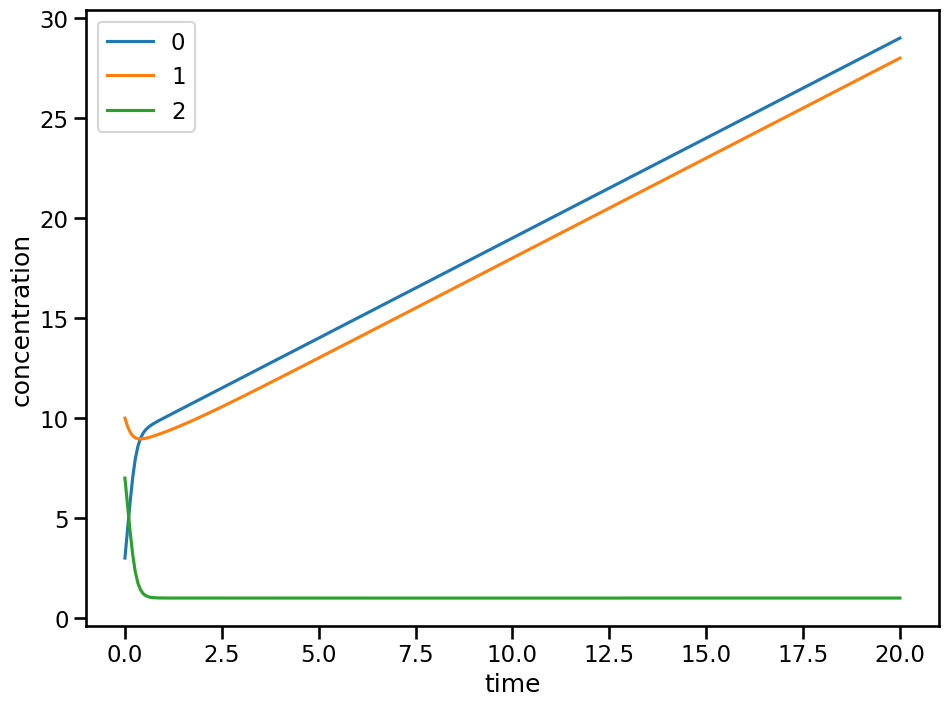

In [7]:
# Sample usage

reactant_matrix = np.array([[0, 0, 0],
                            [1, 0, 0],
                            [1, 0, 1],
                            [0, 1, 0]])

product_matrix = np.array([[1, 0, 0],
                           [0, 1, 1],
                           [2, 0, 0],
                           [0, 0, 0]])

t_span = [0, 20]
y_initial = [3, 10, 7]
k = [1, 1, 1, 1]

# Solve ivp with module in scipy.integrate 
sol = solve_ivp(dydt, t_span, y_initial, args = (reactant_matrix, product_matrix, k), dense_output=True)


t = np.linspace(0, 20, 300)
y = sol.sol(t)
import matplotlib.pyplot as plt
plt.plot(t, y.T)
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend(np.arange(len(y_initial)))
plt.show()

Decorator
========

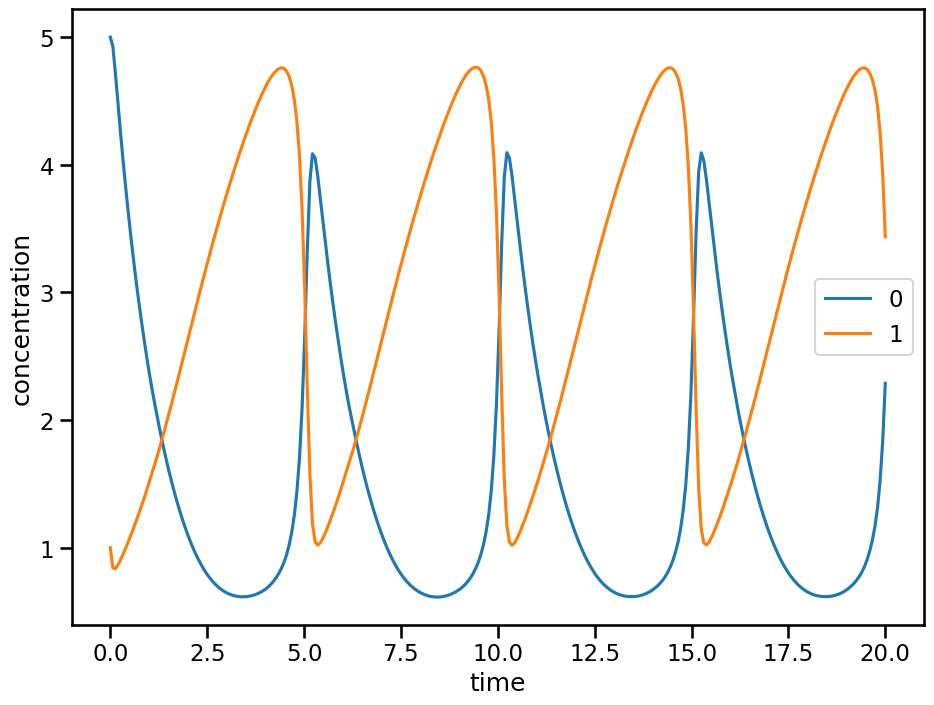

In [8]:
def dydt_scalar_decorator(dydt):
    def wrapper(*args):
        if len(args) < 2:
            raise TypeError("The decorated function requires at least two positional arguments.")
            
        # Extract the scalar argument from the last position
        scalar = args[-1]

        # Extract the argument to be multiplied by scalar
        arg_index_to_multiply = 4
        arg_to_multiply = args[arg_index_to_multiply]

        # Multiply the selected argument by scalar
        args_list = list(args)
        args_list[arg_index_to_multiply] = arg_to_multiply * scalar
        args = tuple(args_list)

        result = dydt(*args[:-1])  # Pass all arguments except the last one (scalar)
        return result
    return wrapper

reactant_matrix = np.array([[0, 0],
                            [2, 1],
                            [1, 0],
                            [1, 0]])

product_matrix = np.array([[1, 0],
                           [3, 0],
                           [0, 1],
                           [0, 0]])

t_span = [0, 20]
y_initial = [5, 1]
k = [1., 1., 1., 1.]
scalar = np.array([1.5,1,4,1]) # [A, 1, B, 1], A = 1.5, B = 4

dydtmodified = dydt_scalar_decorator(dydt)

# Solve ivp with module in scipy.integrate 
solmodified = solve_ivp(dydtmodified, t_span, y_initial,
                        args = (reactant_matrix, product_matrix, k, scalar),
                                dense_output=True)


t = np.linspace(0, 20, 300)
y = solmodified.sol(t)
import matplotlib.pyplot as plt
plt.plot(t, y.T)
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend(np.arange(len(y_initial)))
plt.show()